# Stock Forecasting using Transformers

In this notebook we implement a Transformer model to forecast stock data.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413

In [2]:
from __future__ import annotations
import glob
import inspect
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import sys
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable

In [3]:
sns.set() # Use seaborn themes.

## Environment Setup

This section contains code that is modifies output path locations, random seed, and logging.

In [4]:
DATASET_ROOT = Path('~/ml/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")
PROJECT_ROOT = Path('~/ml/ece_6524/final_project').expanduser()
CHECKPOINT_ROOT = PROJECT_ROOT / 'checkpoints'
IMAGE_ROOT = PROJECT_ROOT / 'images'
TABLE_ROOT = PROJECT_ROOT / 'tables'
HP_TUNING_ROOT = PROJECT_ROOT / 'hp_tuning'

# Ensure some directories exist.
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
IMAGE_ROOT.mkdir(parents=True, exist_ok=True)
TABLE_ROOT.mkdir(parents=True, exist_ok=True)
HP_TUNING_ROOT.mkdir(parents=True, exist_ok=True)

In [5]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED) # Only this works on ARC (since tensorflow==2.4).

In [6]:
# Setup logging (useful for ARC systems).
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Must be lowest of all handlers listed below.
while logger.hasHandlers(): logger.removeHandler(logger.handlers[0]) # Clear all existing handlers.

# Custom log formatting.
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

# Log to STDOUT (uses default formatting).
sh = logging.StreamHandler(stream=sys.stdout)
sh.setLevel(logging.INFO)
logger.addHandler(sh)

# Set Tensorflow logging level.
tf.get_logger().setLevel('ERROR') # 'INFO'

In [7]:
# Request user for Kaggle login if JSON file does not exist.
kaggle_config_file = Path("~/.kaggle/kaggle.json").expanduser()
if not kaggle_config_file.exists() and os.environ.get("KAGGLE_USERNAME", None) is None and os.environ.get("KAGGLE_KEY", None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Please enter your Kaggle username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:
        api_key = getpass.getpass(prompt="Please enter your Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key
else:
    logger.info('Kaggle API configured')

Kaggle API configured


In [8]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
logger.info(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    logger.info(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


## Huge Stock Market Dataset from Kaggle

https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [9]:
class HugeStockMarketDataset:
    """Wrapper for Huge Stock Market Dataset by Boris Marjanovic on Kaggle.

    Source URL is: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

    This class can be used like a Python dictionary, where keys are the stock/etf names, and values are
    `pandas.DataFrame` objects corresponding to that stock/etf.
    """
    root = 'HugeStockMarketDataset'

    def __init__(self, 
        path: str,
        files: list = None,
        quiet: bool = False,
        exclude_stocks: bool = False,
        exclude_etfs: bool = False,
        usecols: list[str] = ['Date','Open','High','Low','Close','Volume','OpenInt'],
        ):
        self.exclude_stocks = exclude_stocks
        self.exclude_etfs = exclude_etfs
        self.usecols = usecols
        self._index = {}

        # Download the dataset if necessary.
        newpath = Path(path).expanduser()/self.root
        if not newpath.exists():
            self.download(newpath, files, quiet=quiet)
        else:
            self.path = newpath
            self._build_index()

    def _build_index(self):
        """Creates an internal index of stocks and ETFs for lookup."""

        # Helper function to index a folder of files.
        def _index_folder(dir: Path):
            for file in glob.iglob(str(dir/'*.txt'), recursive=True):
                filename = Path(file).name
                product_name = filename.split('.', maxsplit=1)[0]
                self._index[product_name] = file

        # Index all stocks.
        if not self.exclude_stocks:
            _index_folder(self.path/'**'/'Stocks')
        
        # Index all ETFs.
        if not self.exclude_etfs:
            _index_folder(self.path/'**'/'ETFs')

    def download(self, path: str, files: list = None, quiet: bool = True):
        """Downloads the dataset from Kaggle.

        Args:
            path (str): The path to place the download.
            files (list, optional): Subset list of files to download instead of entire dataset. Defaults to None.
            quiet (bool, optional): Suppress verbose output. Defaults to True.
        """
        import kaggle
        kaggle_dataset = 'borismarjanovic/price-volume-data-for-all-us-stocks-etfs'
        kaggle.api.authenticate()

        # Save the new downloaded path.
        self.path = Path(path).expanduser()

        # Specific file list was given.
        if files is not None:
            for f in files:
                kaggle.api.dataset_download_file(
                    dataset=kaggle_dataset,
                    file_name=f,
                    path=path/f,
                    quiet=quiet,
                )
        # Download all files.
        else:
            kaggle.api.dataset_download_files(
                dataset=kaggle_dataset,
                path=path,
                unzip=True,
                quiet=quiet,
            )

        # Force rebuild the index after downloading.
        logger.info("Building file index")
        self._build_index()

    def get_dataframe(self, 
        key: str,
        **kwargs,
        ) -> pd.DataFrame:
        """Obtain historical data for stock or ETF in a pandas dataframe.

        Optional keyword arguments are passed directly to `pandas.read_csv` function.

        Args:
            key (str): The identifier for the stock or ETF.

        Returns:
            pd.DataFrame: Historical data.
        """
        return pd.read_csv(self._index[key], **kwargs)

    #### Dictionary Override ######

    def __getitem__(self, key):
        if isinstance(key, str):
            return self.get_dataframe(key, usecols=self.usecols)
        elif isinstance(key, list):
            return [self.get_dataframe(asset, usecols=self.usecols) for asset in key]

    def __delitem__(self, key):
        del self._index[key]

    def __iter__(self):
        return iter(self._index)

    def items(self):
        for key in self:
            yield key, self.get_dataframe(key, usecols=self.usecols)

    def __len__(self):
        return len(self._index)

    def keys(self):
        """Returns a list of all downloaded stocks and ETFs."""
        return self._index.keys()

    ###############################

In [10]:
# Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
class WindowGenerator:
    def __init__(self,
        in_seq_len: int,
        out_seq_len: int,
        shift: int,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        in_feat: list[str] = None,
        out_feat: list[str] = None,
        batch_size: int = 32,
        shuffle: bool = True,
        ):
        """Constructs sliding windows of sequential data.

        Data must already be split into train/val/test subsets,
        and provided as `pandas.DataFrame` objects.

        Args:
            in_seq_len (int): Input sequence length.
            out_seq_len (int): Output (target) sequence length.
            shift (int): Number of indices to skip between elements when traversing window.
            train_df (pd.DataFrame): Training data frame.
            val_df (pd.DataFrame): Validation data frame.
            test_df (pd.DataFrame): Testing data frame.
            in_feat (list[str], optional): Desired subset of input features for window. Defaults to None.
            out_feat (list[str], optional): Desired subset of output features for window. Defaults to None.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Preserve dataframes.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Preserve sequence information.
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.shift = shift
        self.total_window_len = in_seq_len + shift

        # Setup indexing slices for window extraction.
        self.in_slice = slice(0, self.in_seq_len)
        self.out_slice = slice(self.total_window_len - self.out_seq_len, None)
        self.in_idx = np.arange(self.total_window_len)[self.in_slice]
        self.out_idx = np.arange(self.total_window_len)[self.out_slice]

        # Setup train/val/test column extractors.
        self.col2idx = {name: i for i, name in enumerate(train_df.columns)}
        if in_feat is not None:
            self.in_feat = in_feat
            self.in_col_idx = [self.col2idx[col] for col in in_feat]
        else:
            self.in_col_idx = list(range(len(train_df.columns)))
            self.in_feat = [train_df.columns[i] for i in self.in_col_idx]
        if out_feat is not None:
            self.out_feat = out_feat
            self.out_col_idx = [self.col2idx[col] for col in out_feat]
        else:
            self.out_col_idx = list(range(len(train_df.columns)))
            self.out_feat = [train_df.columns[i] for i in self.out_col_idx]

    def __repr__(self):
        """String representation of class."""
        return '\n'.join([
            f"Total window length: {self.total_window_len}",
            f"Input indices: {self.in_idx}",
            f"Output indices: {self.out_idx}",
            f"Input features: {self.in_feat}",
            f"Output features: {self.out_feat}",
        ])

    def split_window(self, 
        window: tf.Tensor, # window shape is (batch, seq, feat)
        ) -> tuple[tf.Tensor, tf.Tensor]:
        """Splits a single window of data into input/output seqments.

        Args:
            window (tf.Tensor): Tensor of window data with shape (batch, seq, feat).

        Returns:
            tuple[tf.Tensor, tf.Tensor]: 2-tuple of input/output data segments, where the shapes are:
                - Input window: (batch, in_seq_len, in_feat)
                - Output window: (batch, out_seq_len, out_feat)
        """
        # Decompose input/output sequence from given input window.
        in_seq = tf.stack([window[:, self.in_slice, i] for i in self.in_col_idx], axis=-1)
        out_seq = tf.stack([window[:, self.out_slice, i] for i in self.out_col_idx], axis=-1)

        # Set shape for input/output sequences.
        # Note that dimensions set to `None` are not updated.
        in_seq = tf.ensure_shape(in_seq, (None, self.in_seq_len, None))
        out_seq = tf.ensure_shape(out_seq, (None, self.out_seq_len, None))

        return in_seq, out_seq

    def make_dataset(self, 
        df: pd.DataFrame,
        batch_size: int = 32,
        shuffle: bool = True,
        ) -> tf.data.Dataset:
        """Construct a TensorFlow Dataset from given input data frame.

        Datasets load tuples of batched input/output windows with shapes:
            - Input window: (batch, in_seq_len, in_feat)
            - Output window: (batch, out_seq_len, out_feat)

        Note that output windows are generally target sequences.

        Args:
            df (pd.DataFrame): Source data frame.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        # Convert data frame into numpy matrix.
        data = df.to_numpy()

        # Convert data matrix into TensorFlow dataset.
        # dataset = keras.utils.timeseries_dataset_from_array(
        dataset = keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_len,
            sequence_stride=self.shift,
            shuffle=shuffle,
            batch_size=batch_size,
        )

        # Pipe the raw dataset into the window splitting function.
        dataset = dataset.map(self.split_window)

        # Return the dataset.
        return dataset

    @property
    def train(self):
        """Training dataset."""
        return self.make_dataset(
            df=self.train_df,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

    @property
    def val(self):
        """Validation dataset."""
        return self.make_dataset(
            df=self.val_df,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

    @property
    def test(self):
        """Testing dataset."""
        return self.make_dataset(
            df=self.test_df,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

In [11]:
def load_stock_dataset(
    assets: str|list[str],
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float], # must sum to 1.
    in_feat: list[str] = ['DayOfYear','Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['DayOfYear','Open','High','Low','Close','Volume'],
    batch_size: int = 32,
    shuffle: bool = True,
    normalize: bool = True,
    return_datasets: bool = True,
    return_df: bool = False,
    return_window: bool = False,
    ) -> None|tuple:
    """Load the history for a single stock within the Huge Stock Market Dataset.

    Args:
        assets (str): Name of stock or ETF to use, or list of names.
        in_seq_len (int): Input sequence length for window.
        out_seq_len (int): Output (target) sequence length for window.
        shift (int): Number of indices to skip when generating window.
        split (tuple[float, float, float]): Tuple of `(train, val, test)` splits. Note that these must sum to `1`.
        in_feat (list[str], optional): Desired subset of input features for window. Defaults to `['DayOfYear','Open','High','Low','Close','Volume']`.
        out_feat (list[str], optional): Desired subset of output features for window. Defaults to `['DayOfYear','Open','High','Low','Close','Volume']`.
        batch_size (int, optional): Batch size. Defaults to 32.
        shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.
        normalize (bool, optional): Normalize the data using mean/std method. Defaults to `True`.
        return_datasets (bool, optional): Return train/val/test datasets. Defaults to `True`.
        return_df (bool, optional): Return original data frame. Defaults to `False`.
        return_window (bool, optional): Return window generator. Defaults to `False`.

    Returns:
        None|tuple: Several return options:
            - `return_datasets=False`, `return_df=False`, `return_window=False`: Returns None.
            - `return_datasets=True`, `return_df=False`, `return_window=False`: Returns tuple of `(train, val, test)` datasets.
            - `return_datasets=False`, `return_df=True`, `return_window=False`: Returns the original dataset `df`.
            - `return_datasets=False`, `return_df=False`, `return_window=True`: Returns the window generator `windowgen`.
            - `return_datasets=True`, `return_df=True`, `return_window=False`: Returns tuple of `((train, val, test), df)`
            - `return_datasets=True`, `return_df=False`, `return_window=True`: Returns tuple of `((train, val, test), windowgen)`
            - `return_datasets=False`, `return_df=True`, `return_window=True`: Returns tuple of `(windowgen, df)`
            - `return_datasets=True`, `return_df=True`, `return_window=True`: Returns tuple of `((train, val, test), df, windowgen)`
    """
    np.testing.assert_almost_equal(sum(split), 1., err_msg='Split must sum to 1.')
    train_split, _, test_split = split

    # Load dataset.
    dataset = HugeStockMarketDataset(DATASET_ROOT, usecols=['Date','Open','High','Low','Close','Volume'])

    # Convert single asset name to list.
    if isinstance(assets, str):
        assets = [assets]

    # Create multiple datasets.
    windows = {}
    frames = {}
    for name in assets:

        # Get dataframe for desired assets.
        df = dataset[name]

        # Convert date string column to datetime objects.
        df['Date'] = pd.to_datetime(df['Date'])

        # Create new `DayOfYear` column.
        df['DayOfYear'] = df['Date'].dt.dayofyear

        # Split dataframe into train/val/test dataframes.
        # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data
        n = len(df.index) # Total number of data records.
        df_train = df[:int(n*train_split)].copy()
        df_val = df[int(n*train_split):int(n*(1-test_split))].copy()
        df_test = df[int(n*(1-test_split)):].copy()

        # Reset the indices to zero.
        df_train.reset_index(inplace=True)
        df_val.reset_index(inplace=True)
        df_test.reset_index(inplace=True)

        # Drop the 'Date' column, so that we only use the floating-point columns.
        df_train.drop(columns=['Date'], inplace=True, errors='ignore')
        df_val.drop(columns=['Date'], inplace=True, errors='ignore')
        df_test.drop(columns=['Date'], inplace=True, errors='ignore')

        # Normalize the datasets using train-data statistics.
        # Note that only the training data is used for statistics.
        # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data
        if normalize:

            # Normalize to 0 mean and 1 std.
            train_mean = df_train.mean()
            train_std = df_train.std()
            df_train = (df_train - train_mean)/train_std
            df_val = (df_val - train_mean)/train_std
            df_test = (df_test - train_mean)/train_std

            #############

            # # Moving average.
            # df_train = df_train.rolling(10).mean()
            # df_val = df_val.rolling(10).mean()
            # df_test = df_test.rolling(10).mean()

            # # Change columns to be percent change in range [0,100].
            # df_train = df_train.pct_change()
            # df_val = df_val.pct_change()
            # df_test = df_test.pct_change()

            # # Normalize between [0,1].
            # train_min = df_train.min()
            # train_max = df_train.max()
            # df_train = (df_train - train_min)/(train_max - train_min)
            # df_val = (df_val - train_min)/(train_max - train_min)
            # df_test = (df_test - train_min)/(train_max - train_min)

        # Preserve the data frames.
        frames[name] = (df, df_train, df_val, df_test)

        # Build window generator for datasets.
        w = WindowGenerator(
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            train_df=df_train,
            val_df=df_val,
            test_df=df_test,
            in_feat=in_feat,
            out_feat=out_feat,
            batch_size=batch_size,
            shuffle=shuffle,
        )
        windows[name] = w

    # Combine all batched datasets.
    train_dataset = windows[assets[0]].train
    val_dataset = windows[assets[0]].val
    test_dataset = windows[assets[0]].test
    for i in range(1, len(assets)):
        train_dataset = train_dataset.concatenate(windows[assets[i]].train)
        val_dataset = val_dataset.concatenate(windows[assets[i]].val)
        test_dataset = test_dataset.concatenate(windows[assets[i]].test)

    # Extract elements for result list.
    result = []
    # Extract train/val/test datasets and return.
    if return_datasets:
        # result.append((w.train, w.val, w.test))
        result.append((train_dataset, val_dataset, test_dataset))
    # Extract the data frame.
    if return_df:
        # result.append((df, df_train, df_val, df_test))
        if len(assets) > 1:
            result.append(frames)
        else:
            result.append(frames[assets[0]])
    # Extract the window generator.
    if return_window:
        # result.append(w)
        if len(assets) > 1:
            result.append(windows)
        else:
            result.append(windows[assets[0]])

    # Return None if nothing was selected to return.
    if len(result) == 0:
        return None
    # Return single element.
    elif len(result) == 1:
        return result[0]
    # Return entire tuple of results.
    else:
        return tuple(result)

Now lets actually load the dataset. In this case, we're looking at several stocks.

Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
Output indices: [128]
Input features: ['DayOfYear', 'Open', 'High', 'Low', 'Close', 'Volume']
Output features: ['DayOfYear', 'Open', 'High', 'Low', 'Close', 'Volume']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.e

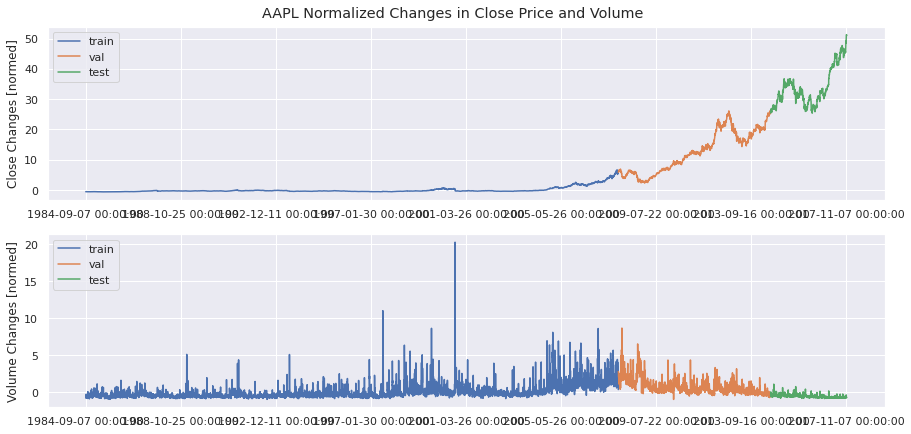

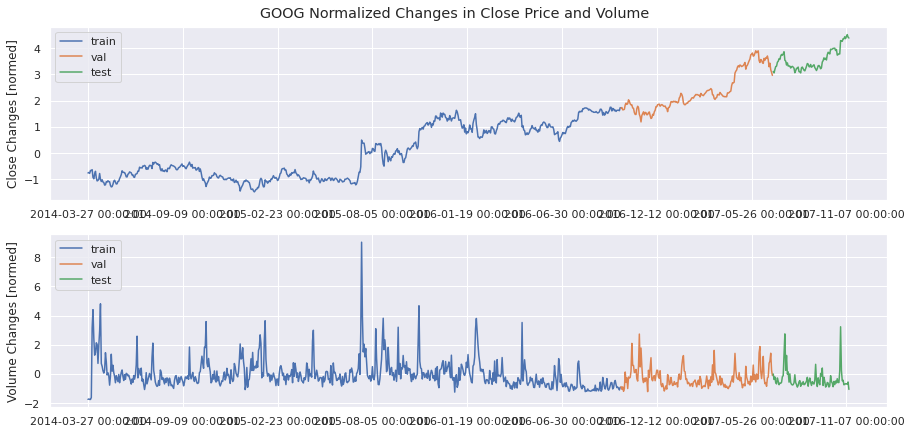

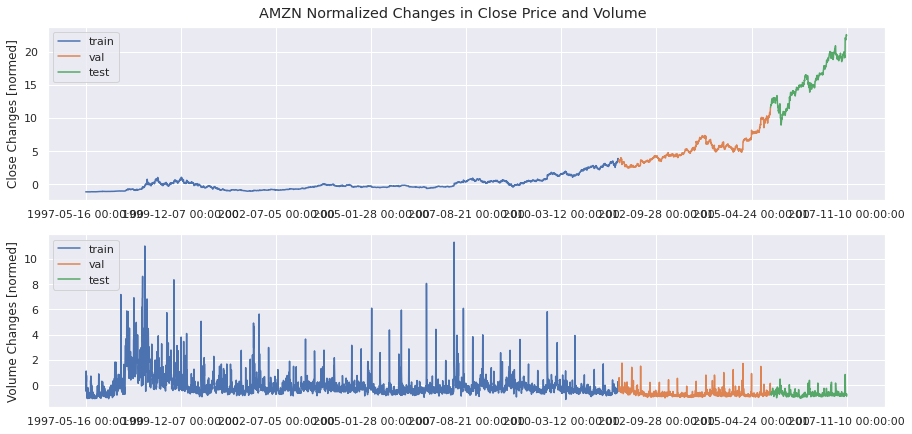

In [12]:
assets = ['aapl', 'goog', 'amzn']

(dataset_train, dataset_val, dataset_test), frames = load_stock_dataset(
    assets=assets,
    in_seq_len=128,
    out_seq_len=1,
    shift=1,
    split=(0.7, 0.2, 0.1),
    shuffle=False,
    normalize=True,
    return_datasets=True,
    return_df=True,
)

# Print information for train/val/test datasets.
# Note that these are combined from all assets.
logger.info(f"train: {tf.data.experimental.cardinality(dataset_train)} batches")
logger.info(f"val: {tf.data.experimental.cardinality(dataset_val)} batches")
logger.info(f"test: {tf.data.experimental.cardinality(dataset_test)} batches")

# Plot the train/val/test data for each asset.
for asset in assets:

    # Unpack the data frames.
    (df, df_train, df_val, df_test) = frames[asset]

    # Plot.
    fig = plt.figure(figsize=(15,7))
    fig.suptitle(f'{asset.upper()} Normalized Changes in Close Price and Volume').set_y(0.92)
    n = len(df.index)//8 # Number of date record ticks on X-axis.
    ax = fig.add_subplot(211)
    ax.plot(np.arange(len(df_train.index)), df_train['Close'], label='train')
    ax.plot(np.arange(len(df_train.index), len(df_train.index)+len(df_val.index)), df_val['Close'], label='val')
    ax.plot(np.arange(len(df_train.index)+len(df_val.index), len(df_train.index)+len(df_val.index)+len(df_test.index)), df_test['Close'], label='test')
    ax.set_ylabel('Close Changes [normed]')
    ax.set_xticks(range(0, df.shape[0], n))
    ax.set_xticklabels(df['Date'].loc[::n])
    ax.legend(loc='upper left')
    ax = fig.add_subplot(212)
    ax.plot(np.arange(len(df_train.index)),df_train['Volume'], label='train')
    ax.plot(np.arange(len(df_train.index), len(df_train.index)+len(df_val.index)),df_val['Volume'], label='val')
    ax.plot(np.arange(len(df_train.index)+len(df_val.index), len(df_train.index)+len(df_val.index)+len(df_test.index)), df_test['Volume'], label='test')
    ax.set_ylabel('Volume Changes [normed]')
    ax.set_xticks(range(0, df.shape[0], n))
    ax.set_xticklabels(df['Date'].loc[::n])
    ax.legend(loc='upper left')

# Free memory.
del dataset_train
del dataset_val
del dataset_test
del frames

## Time2Vec Embedding

https://arxiv.org/abs/1907.05321

In [13]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, embed_dim: int, activation: str = 'sin', **kwargs):
        """Vector embedding representation of time.

        Based on the original concept proposed by Kazemi et al., 2019 (https://arxiv.org/abs/1907.05321).

        This layer operates on a single time step with N feature dimensions. When using this layer for multi-time-step
        datasets, you must pass this layer through a `keras.layers.TimeDistributed` layer to multiplex this for all time steps.

        Note that embedding is done on a per-feature basis. For example, using an input record with 7 features (i.e., shape=(1, 7))
        and an embeddding dimension of 10, the resulting embedding would have 70 dimensions (i.e., shape=(1, 70)). This is because
        each of the 7 features gets a 10-dimensional embedding.

        Args:
            embed_dim (int): Length of the time embedding vector.
            activation (str, optional): Periodic activation function. Possible values are ['sin', 'cos']. Defaults to 'sin'.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim # Embed dimension is k+1.
        self.activation = activation.lower() # Convert to lower-case.

        # Set periodic activation function.
        if self.activation.startswith('sin'):
            self.activation_func = tf.sin
        elif self.activation.startswith('cos'):
            self.activation_func = tf.cos
        else:
            raise ValueError(f'Unsupported periodic activation function "{activation}"')

    def build(self, input_shape: list[int]):

        # Weight and bias term for linear portion (i = 0)
        # of embedding.
        self.w_linear = self.add_weight(
            name='w_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )
        self.b_linear = self.add_weight(
            name='b_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )

        # Weight and bias terms for the periodic
        # portion (1 <= i <= k) of embedding.
        self.w_periodic = self.add_weight(
            name='w_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )
        self.b_periodic = self.add_weight(
            name='b_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Embed input into linear and periodic feature components.

        Args:
            x (tf.Tensor): Input tensor with shape (sequence_length, feature_size)

        Returns:
            tf.Tensor: Output tensor with shape (sequence_length, feature_size * embed_dim)
        """
        # Linear term (i = 0).
        embed_linear = self.w_linear * x + self.b_linear
        embed_linear = tf.expand_dims(embed_linear, axis=-1) # Reshape to (sequence_length, feature_size, 1)

        # Periodic terms (1 <= i <= k).
        inner = keras.backend.dot(x, self.w_periodic) + self.b_periodic
        embed_periodic = self.activation_func(inner) # (sequence_length, feature_size, embed_dim - 1)

        # Return concatenated linear and periodic features.
        ret = tf.concat([embed_linear, embed_periodic], axis=-1) # (sequence_length, feature_size, embed_dim)
        ret = tf.reshape(ret, (-1, x.shape[1]*self.embed_dim)) # (sequence_length, feature_size * embed_dim)
        return ret

    def compute_output_shape(self, input_shape: tf.TensorShape) -> tf.TensorShape:
        """Determines the output shape for a given input shape.

        Args:
            input_shape (tf.TensorShape): Input shape (sequence_length, feature_size).

        Returns:
            tf.TensorShape: Output shape (sequence_length, feature_size * embed_dim).
        """
        return tf.TensorShape((input_shape[0], input_shape[1]*self.embed_dim))

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'activation': self.activation,
        })
        return config


# Update custom objects dictionary.
keras.utils.get_custom_objects()['Time2Vec'] = Time2Vec



# stock_feat = 7
# seq_len = 128
# embed_dim = 10
# inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{inp.shape=}")
# x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
# logger.info(f"{x.shape=}")
# x = keras.layers.Concatenate(axis=-1)([inp, x])
# logger.info(f"{x.shape=}")

## Transformer Architecture

https://arxiv.org/abs/1706.03762

### Attention Layers

Currently uses attention layers provided by TensorFlow. See https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.

### Point-wise Feed Forward Network

https://www.tensorflow.org/text/tutorials/transformer#point_wise_feed_forward_network

In [14]:
class PointWiseFeedForwardLayer(keras.layers.Layer):
    def __init__(self, dims: list[int], activation: str = 'gelu', **kwargs):
        """Generic point-wise feed forward layer subnetwork.

        Args:
            dims (list[int]): List of dense layer dimensions. The length of the list determines the number of dimensions. Must be at least 2 dimensions given.
            activation (str, optional): Activation function to use for the first `N-1` dense layers. The final layer has no activation.
        """
        super().__init__(**kwargs)
        assert len(dims) > 1 # Must provide at least 2 dimensions.
        self.dims = dims
        self.n_dim = len(self.dims)
        self.activation = activation

    def build(self, input_shape):
        self.ff_layers = []
        for i, dim in enumerate(self.dims):
            if i < self.n_dim-1:
                self.ff_layers.append(keras.layers.Dense(dim, activation=self.activation))
            else:
                self.ff_layers.append(keras.layers.Dense(dim))

    def call(self, x):
        for i in range(self.n_dim):
            x = self.ff_layers[i](x)
        return x

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'dims': self.dims,
            'activation': self.activation,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['PointWiseFeedForwardLayer'] = PointWiseFeedForwardLayer






# inp = keras.Input(shape=(128, 5))
# logger.info(f"{inp.shape=}")
# x = PointWiseFeedForwardLayer(dims=[2048, 32], activation='gelu')(inp)
# logger.info(f"{x.shape=}")

### Transformer Encoder Layer

https://www.tensorflow.org/text/tutorials/transformer#encoder_layer

In [15]:
class TransformerEncoderLayer(keras.layers.Layer):
    def __init__(self,
        model_dim: int,
        n_heads: int,
        key_dim: int = None,
        value_dim: int = None,
        ff_dim: int = 2048,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer encoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            model_dim (int): Encoder input and output feature dimensions.
            n_heads (int): Number of attention heads.
            key_dim (int, optional): Key dimension. If `None` is specified then defaults to `int(model_dim/n_heads)`. Defaults to `None`.
            value_dim (int, optional): Value dimension. If None is specified the Key dimension will be used. Defaults to `None`.
            ff_dim (int): Dimension of the feed forward sublayer.
            dropout (float, optional): Dropout rate. Defaults to `0.0`.
        """
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.n_heads = n_heads # Number of attention heads.
        if key_dim is None:
            self.key_dim = int(model_dim/n_heads)
        else:
            self.key_dim = key_dim
        if value_dim is None:
            self.value_dim = int(model_dim/n_heads)
        else:
            self.value_dim = value_dim
        self.ff_dim = ff_dim
        self.dropout = dropout

    def build(self, input_shape: tf.TensorShape):

        # First sublayer.
        # Multi-head attention with add and norm.
        self.attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        self.attn_multi._build_from_signature(input_shape, input_shape, input_shape)
        self.attn_dropout = keras.layers.Dropout(rate=self.dropout)
        self.attn_add = keras.layers.Add()
        # self.attn_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm = keras.layers.BatchNormalization()

        # Second sublayer.
        # Point-wise feed forward network with add and norm.
        # d_query_feat = input_shape[0][-1] # Query feature size.
        self.ff_net = PointWiseFeedForwardLayer(
            dims=[self.ff_dim, self.model_dim],
            activation='gelu',
        )
        self.ff_dropout = keras.layers.Dropout(rate=self.dropout)
        self.ff_add = keras.layers.Add()
        # self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ff_norm = keras.layers.BatchNormalization()

    def call(self, 
        x: tf.Tensor,
        training: bool = False,
        ) -> tf.Tensor:
        """Encode input using multi-head self-attention mechanisms.

        Args:
            x (tf.Tensor): Batched input sequence into the encoder layer with shape `(batch_size, sequence_length, model_dim)`.
            training (bool, optional): Indicates whether the `call` is meant for training or inference. Defaults to `False`.

        Returns:
            tf.Tensor: Output tensor with shape (batch_size, sequence_length, model_dim)
        """
        # x = (query, value, key)
        # note that "key" is optional.

        # First, do the attention sublayer.
        x_attn = self.attn_multi(x, x, x) # Unpack input as Query, Value, and optional Key.
        x_attn = self.attn_dropout(x_attn, training=training)
        x_attn = self.attn_add([x, x_attn]) # (residual) Add Query matrix with result of attention layer.
        x_attn = self.attn_norm(x_attn, training=training) # Normalize the residual.

        # Second, do the feed forward sublayer.
        x_ff = self.ff_net(x_attn)
        x_ff = self.ff_dropout(x_ff, training=training)
        x_ff = self.ff_add([x_attn, x_ff])
        x_ff = self.ff_norm(x_ff, training=training)

        # Return output of feed forward sublayer.
        return x_ff

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'model_dim': self.model_dim,
            'n_heads': self.n_heads,
            'key_dim': self.key_dim,
            'ff_dim': self.ff_dim,
            'value_dim': self.value_dim,
            'dropout': self.dropout,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['TransformerEncoderLayer'] = TransformerEncoderLayer










# stock_feat = 5
# seq_len = 128
# embed_dim = 32
# # model_dim = 512
# inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{inp.shape=}")
# x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
# logger.info(f"Time2Vec {x.shape=}")
# x = keras.layers.Concatenate(axis=-1)([inp, x])


# model_dim = x.shape[-1]
# n_heads = 8
# # key_dim = int(model_dim/n_heads)
# # value_dim = int(model_dim/n_heads)
# ff_dim = 2048
# logger.info(f"{model_dim=}")
# logger.info(f"{n_heads=}")
# logger.info(f"{ff_dim=}")

# logger.info(f"Concatenate {x.shape=}")
# x = TransformerEncoderLayer(model_dim=model_dim, n_heads=n_heads, ff_dim=ff_dim)(x)
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = TransformerEncoderLayer(model_dim=model_dim, n_heads=n_heads, ff_dim=ff_dim)(x)
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = TransformerEncoderLayer(model_dim=model_dim, n_heads=n_heads, ff_dim=ff_dim)(x)
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x)
# logger.info(f"GlobalAvgPool1D {x.shape=}")

### Transformer Decoder Layer

https://www.tensorflow.org/text/tutorials/transformer#decoder_layer


In [16]:
class TransformerDecoderLayer(keras.layers.Layer):
    def __init__(self,
        model_dim: int,
        key_dim: int,
        n_heads: int,
        ff_dim: int,
        value_dim: int = None,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer decoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            model_dim (int): Decoder input and output feature dimensions.
            key_dim (int): Key dimension.
            n_heads (int): Number of attention heads.
            ff_dim (int): Dimension of the feed forward sublayer.
            value_dim (int, optional): Value dimension. If None is specified the Key dimension will be used. Defaults to None.
            dropout (float, optional): Dropout rate. Defaults to 0.0.
        """
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.key_dim = key_dim
        self.value_dim = value_dim
        self.n_heads = n_heads # Number of attention heads.
        self.ff_dim = ff_dim
        self.dropout = dropout

    def build(self, input_shape: tuple[tf.TensorShape,tf.TensorShape]):
        print(f"{input_shape}")
        assert len(input_shape) == 2

        #### First sublayer ####
        # Masked multi-head self-attention with add and norm.
        self.l1_attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        # self.l1_attn_multi._build_from_signature(input_shape[0], input_shape[0], input_shape[0])
        self.l1_dropout = keras.layers.Dropout(rate=self.dropout)
        self.l1_add = keras.layers.Add()
        # self.l1_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.l1_norm = keras.layers.BatchNormalization()

        #### Second sublayer ####
        # Multi-head attention with add and norm.
        self.l2_attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        # self.l2_attn_multi._build_from_signature(input_shape[-1], input_shape[-1], self.l1_attn_multi.shape)
        self.l2_dropout = keras.layers.Dropout(rate=self.dropout)
        self.l2_add = keras.layers.Add()
        # self.l2_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.l2_norm = keras.layers.BatchNormalization()

        #### Third sublayer ####
        # Point-wise feed forward network with add and norm.
        # d_query_feat = input_shape[0][-1] # Query feature size.
        self.l3_ff = PointWiseFeedForwardLayer(
            dims=[self.ff_dim, self.model_dim],
            activation='gelu',
        )
        self.l3_dropout = keras.layers.Dropout(rate=self.dropout)
        self.l3_add = keras.layers.Add()
        # self.l3_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.l3_norm = keras.layers.BatchNormalization()

    def call(self,
        x: tuple[tf.Tensor, tf.Tensor],
        look_ahead_mask: tf.Tensor = None,
        memory_mask: tf.Tensor = None,
        training: bool = False,
        return_attention_scores: bool = False,
        ) -> tf.Tensor|tuple[tf.Tensor,tuple[tf.Tensor,tf.Tensor]]:
        """Decode input using multi-head attention.

        Accepts decoder input sequence `x` and `memory` sequence 
        (often the output of the last encoder layer).

        Args:
            x (tuple[tf.Tensor, tf.Tensor]): List of batched decoder input sequence, and batched memory sequence (often the output of the last encoder layer).
            look_ahead_mask (tf.Tensor, optional): Attention mask for the decoder input sequence. Defaults to `None`.
            memory_mask (tf.Tensor, optional): Attention mask for the memory sequence. Defaults to `None`.
            training (bool, optional): Indicates whether the `call` is meant for training or inference. Defaults to `False`.
            return_attention_scores (bool, optional): Indicates whether the output is `(attention_output, attention_scores)` if `True`, or `attention_output` if `False`. Defaults to `False`.

        Returns:
            tf.Tensor|tuple[tf.Tensor,tuple[tf.Tensor,tf.Tensor]]: Output depends on `return_attention_scores` value.  Returns `(attention_output, attention_scores)` if `return_attention_scores=True`, or `attention_output` if `return_attention_scores=False`.
        """
        # Unpack target and memory from input list.
        target, memory = x

        # Self-attention input layer.
        x_l1_attn, x_l1_attn_weights = self.l1_attn_multi(
            target, target, target,
            attention_mask=look_ahead_mask,
            return_attention_scores=True,
        )
        x_l1_attn = self.l1_dropout(x_l1_attn, training=True)
        out_l1 = self.l1_add([x_l1_attn, target])
        out_l1 = self.l1_norm(out_l1, training=training)

        logger.info(f"{out_l1.shape=}")

        # Second attention layer with previous encoder input.
        x_l2_attn, x_l2_attn_weights = self.l2_attn_multi(
            memory, memory, out_l1,
            attention_mask=memory_mask,
            return_attention_scores=True,
        )
        x_l2_attn = self.l2_dropout(x_l2_attn, training=training)
        logger.info(f"{x_l2_attn.shape=}")
        out_l2 = self.l2_add([x_l2_attn, out_l1])
        out_l2 = self.l2_norm(out_l2, training=training)

        # Third layer with point-wise feed forward network.
        x_l3 = self.l3_ff(out_l2)
        x_l3 = self.l3_dropout(x_l3, training=training)
        out_l3 = self.l3_add([x_l3, out_l2])
        out_l3 = self.l3_norm(out_l3, training=training)

        # Return attention scores.
        if return_attention_scores:
            return out_l3, (x_l1_attn_weights, x_l2_attn_weights)
        # Return final layer output.
        else:
            return out_l3

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'model_dim': self.model_dim,
            'n_heads': self.n_heads,
            'key_dim': self.key_dim,
            'ff_dim': self.ff_dim,
            'value_dim': self.value_dim,
            'dropout': self.dropout,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['TransformerDecoderLayer'] = TransformerDecoderLayer











# stock_feat = 5
# seq_len = 128
# embed_dim = 32
# # model_dim = 512
# inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{inp.shape=}")
# x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
# logger.info(f"Time2Vec {x.shape=}")
# x = keras.layers.Concatenate(axis=-1)([inp, x])


# model_dim = x.shape[-1]
# n_heads = 8
# key_dim = int(model_dim/n_heads)
# value_dim = int(model_dim/n_heads)
# ff_dim = 2048
# logger.info(f"{model_dim=}")
# logger.info(f"{n_heads=}")
# logger.info(f"{key_dim=}")
# logger.info(f"{value_dim=}")
# logger.info(f"{ff_dim=}")

# decoder_inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{decoder_inp.shape=}")
# decoder_inp_embed = keras.layers.TimeDistributed(Time2Vec(embed_dim))(decoder_inp)
# logger.info(f"Time2Vec {decoder_inp.shape=}")
# decoder_inp = keras.layers.Concatenate(axis=-1)([decoder_inp, decoder_inp_embed])
# logger.info(f"Concatenate {decoder_inp.shape=}")


# x = TransformerEncoderLayer(model_dim=model_dim, key_dim=key_dim, value_dim=value_dim, n_heads=n_heads, ff_dim=ff_dim)(x)
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = TransformerDecoderLayer(model_dim=model_dim, key_dim=key_dim, value_dim=value_dim, n_heads=n_heads, ff_dim=ff_dim)([decoder_inp, x])
# logger.info(f"TransformerDecoderLayer {x.shape=}")
# x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x)
# logger.info(f"GlobalAvgPool1D {x.shape=}")

### Model Definition

In [17]:
def build_transformer_encoder_net(
    in_seq_len: int,
    in_feat: int,
    out_feat: int,
    fc_units: list[int], # list of fully-connected dimensions before classifier.
    embed_dim: int,
    n_heads: int,
    key_dim: int = None,
    value_dim: int = None,
    ff_dim: int = 2048,
    dropout: float = 0.0,
    n_encoders: int = 3,
    ):

    # Input sequence of features.
    inp = keras.Input(shape=(in_seq_len, in_feat))
    # Time embedding.
    x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
    # Combine input with embedding to form attention input features.
    x = keras.layers.Concatenate(axis=-1)([inp, x])
    # Set model dimension, since Time2Vec embedding is dynamic.
    model_dim: int = x.shape[-1]
    # Pass combined featured through cascaded self-attention encoder sublayers.
    for _ in range(n_encoders):
        x = TransformerEncoderLayer(
            model_dim=model_dim,
            key_dim=key_dim,
            n_heads=n_heads,
            ff_dim=ff_dim,
            value_dim=value_dim,
            dropout=dropout,
        )(x)
    # Downsample to the original sequence dimension.
    x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
    x = keras.layers.Dropout(rate=dropout)(x)
    # Fully-connected network before classifier.
    for units in fc_units: 
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=dropout)(x)
    # Classifier.
    x = keras.layers.Dense(units=out_feat, activation='linear')(x)

    # Construct model class and return.
    return keras.Model(inputs=inp, outputs=x)




# kwargs = dict(
#     in_seq_len=128, # Number of days in the past.
#     in_feat=5, # Number of features for each day in the past.
#     out_feat=3, # Number of features on 1-day horizon.
#     fc_units=[64,64],
#     embed_dim=32,
#     key_dim=512,
#     value_dim=256,
#     n_heads=8,
#     ff_dim=512,
# )
# model = build_transformer_encoder_net(**kwargs)
# model.summary()

## Generalized Model Training and Evaluation

In [18]:
# Gleaned from: https://www.tensorflow.org/text/tutorials/transformer#optimizer
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = {
            'd_model': self.d_model.numpy(),
            'warmup_steps': self.warmup_steps,
        }
        return config

In [19]:
def build_model_from_hparams(func):
    """Generalized model build and compile from hyperparameters."""
    def wrapper(hparams: dict, compile_params: dict):
        """Builds model using given hyperparameters for both model and optimizer, and compile parameters for compilation."""
        # Extract paramters needed for the model.
        model_params = {k: hparams[k] for k in inspect.signature(func).parameters if k in hparams}
        # Build model.
        model = func(**model_params)
        # Configure optimizer.
        optim = keras.optimizers.get({
            'class_name': hparams['optim'],
            'config': {
                'lr': hparams['lr'],
                # 'lr': CustomSchedule(512),
            },
        })
        # Compile the model.
        model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])
        return model
    return wrapper



# builder = build_model_from_hparams(build_transformer)
# hparams = dict(
#     in_seq_len=128, # Number of days in the past.
#     in_feat=5, # Number of features for each day in the past.
#     out_feat=3, # Number of features on 1-day horizon.
#     fc_units=[64,64],
#     embed_dim=32,
#     d_k=512,
#     d_v=256,
#     n_heads=8,
#     d_ff=512,
#     optim='adam',
#     lr=0.001,
# )
# compile_params = dict(
#     loss='mse',
#     metrics=['mae', 'mape'],
# )
# model = builder(hparams, compile_params)
# model.summary()

In [20]:
def load_metrics(metrics_path: str):
    """Load model metrics from file."""
    with open(metrics_path, 'r') as f:
        return json.load(f)

def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)

def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path, 
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model

In [21]:
class LearningRateLoggingCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable):
            lr = lr.numpy()
        else:
            lr = keras.backend.get_value(
                # self.model.optimizer.lr(self.model.optimizer.iterations)
                self.model.optimizer.learning_rate(self.model.optimizer.iterations)
            )
        logger.info(f"Epoch {epoch}: learning rate {lr}")
        # tf.summary.scalar('learning rate', data=lr, step=epoch)

In [22]:
def train_evaluate_model(
    model,
    model_name: str,
    datagen_train: tf.data.Dataset,
    datagen_val: tf.data.Dataset,
    datagen_test: tf.data.Dataset,
    epochs: int,
    metric_list: list[str],
    checkpoint_path: str,
    history_path: str = None,
    metrics_path: str = None,
    ) -> tuple[keras.models.Model, dict, dict]:
    """Trains and evaluates a given model on the given datasets.

    Args:
        model (_type_): The model to train and evaluation.
        model_name (str): String identifier for the model (used when saving some log files).
        datagen_train (tf.data.Dataset): Training dataset.
        datagen_val (tf.data.Dataset): Validation dataset.
        datagen_test (tf.data.Dataset): Testing dataset.
        epochs (int): Number of training epochs.
        checkpoint_path (str): Path to checkpoint file
        history_path (str, optional): Path to history CSV file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"history.csv"`. Defaults to None.
        metrics_path (str, optional): Path to metrics JSON file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"metrics.json"`. Defaults to None.

    Returns:
        tuple[keras.models.Model, dict, dict: Tuple of trained model, history dictionary, and metrics dictionary.
    """

    # Ensure checkpoint root directory has been created.
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    if history_path is None:
        history_path = checkpoint_path.parent/'history.csv'
    if metrics_path is None:
        metrics_path = checkpoint_path.parent/'metrics.json'

    # List of callbacks during training.
    callbacks = [
        # Save model checkpoint after every epoch.
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1,
        ),
        # Log training history to CSV file.
        keras.callbacks.CSVLogger(
            filename=history_path,
            append=False,
        ),
        # Early stopping when performance does not improve across N epochs.
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='auto',
            patience=10,
            # min_delta=0.001,
            restore_best_weights=True,
        ),
        # Learning rate logging.
        LearningRateLoggingCallback(),
    ]

    # Train the model.
    history = model.fit(datagen_train,
        validation_data=datagen_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Evaluate the newly trained model.
    test_metrics = model.evaluate(datagen_test)

    # Create dictionary of metrics to return and preserve in file.
    metrics = {}
    for i, key in enumerate(metric_list):
        metrics[key] = history.history[key][-1]
        metrics[f"val_{key}"] = history.history[f"val_{key}"][-1]
        metrics[f"test_{key}"] = test_metrics[i+1]
    metrics['loss'] = history.history['loss'][-1]
    metrics['val_loss'] = history.history['val_loss'][-1]
    metrics['test_loss'] = test_metrics[0]

    # Dump metrics to JSON file.
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    return model, history.history, metrics

In [23]:
def plot_metric(history: dict, metric: str, model_name: str) -> plt.Figure:
    """Plots model training and validation metric."""
    fig = plt.figure()
    plt.plot(history[metric], label='train')
    plt.plot(history[f"val_{metric}"], label='val')
    plt.xlim(0, len(history[metric])-1)
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.title(f"{model_name} {metric.upper()}")
    plt.legend(loc='upper left')
    return fig

In [36]:
def plot_predictions(
    model: keras.models.Model,
    hparams: dict,
    assets: str|list[str],
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float] = (0.7, 0.2, 0.1),
    in_feat: list[str] = ['DayOfYear','Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['DayOfYear','Open','High','Low','Close','Volume'],
    batch_size: int = 64,
    shuffle: bool = True,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    ) -> dict[str, plt.Figure]:

    # Plot each asset independently.
    figs = {}
    for asset in assets:

        # Load on device.
        with strategy.scope():

            # Load the dataset.
            (dataset_train, dataset_val, dataset_test), (_, df_train, df_val, df_test) = load_stock_dataset(
                assets=asset,
                in_seq_len=in_seq_len,
                out_seq_len=out_seq_len,
                shift=shift,
                split=split,
                in_feat=in_feat,
                out_feat=out_feat,
                batch_size=batch_size,
                shuffle=shuffle,
                return_df=True,
            )

            # Evaluate the model on the train/val/test data.
            train_pred = model.predict(dataset_train)
            val_pred = model.predict(dataset_val)
            test_pred = model.predict(dataset_test)

        # Create main figure.
        fig = plt.figure(figsize=(15,20))
        st = fig.suptitle(f"{asset.upper()} -- Transformer + Time2Vec Model", fontsize=22)
        st.set_y(0.92)

        # # Add parameter text.
        # text = '\n'.join(f"{k}={v}" for k, v in hparams.items() if k != 'lr')
        # plt.figtext(0.92, 0.5, text, fontsize=14)

        # Plot training truth and predictions.
        ax11 = fig.add_subplot(311)
        ax11.plot(df_train['Close'], label=f'{asset.upper()} Closing Returns')
        ax11.plot(np.arange(in_seq_len, train_pred.shape[0]+in_seq_len), train_pred, linewidth=3, label=f'Predicted {asset.upper()} Closing Returns')
        ax11.set_title("Training Data", fontsize=18)
        ax11.set_xlabel('Index')
        ax11.set_ylabel(f'{asset.upper()} Closing Returns')
        ax11.legend(loc="best", fontsize=12)

        # Plot validation truth and predictions.
        ax12 = fig.add_subplot(312)
        ax12.plot(df_val['Close'], label=f'{asset.upper()} Closing Returns')
        ax12.plot(np.arange(in_seq_len, val_pred.shape[0]+in_seq_len), val_pred, linewidth=3, label=f'Predicted {asset.upper()} Closing Returns')
        ax12.set_title("Validation Data", fontsize=18)
        ax12.set_xlabel('Index')
        ax12.set_ylabel(f'{asset.upper()} Closing Returns')
        ax12.legend(loc="best", fontsize=12)

        # Plot testing truth and predictions.
        ax13 = fig.add_subplot(313)
        ax13.plot(df_test['Close'], label=f'{asset.upper()} Closing Returns')
        ax13.plot(np.arange(in_seq_len, test_pred.shape[0]+in_seq_len), test_pred, linewidth=3, label=f'Predicted {asset.upper()} Closing Returns')
        ax13.set_title("Testing Data", fontsize=18)
        ax13.set_xlabel('Index')
        ax13.set_ylabel(f'{asset.upper()} Closing Returns')
        ax13.legend(loc="best", fontsize=12)

        # Preserve figure.
        figs[asset] = fig

    # Return figures.
    return figs

In [37]:
def train_evaluate_for_dataset(
    model_name: str,
    build_model_func,
    params: dict,
    compile_params: dict,
    assets: str|list[str],
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float] = (0.7, 0.2, 0.1),
    in_feat: list[str] = ['DayOfYear','Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['DayOfYear','Open','High','Low','Close','Volume'],
    batch_size: int = 64,
    shuffle: bool = False,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    epochs: int = 10,
    ) -> tuple[keras.models.Model, dict, dict, dict, pd.DataFrame]:
    """Train and evaluate a model on a given dataset.

    If checkpoint exists then the model is loaded in place of training.
    """

    # Convert single asset name to list.
    if isinstance(assets, str):
        assets = [assets]

    # Train and evaluate model.
    checkpoint_path = CHECKPOINT_ROOT/model_name/'model.h5'
    history_path = checkpoint_path.parent/'history.csv'
    metrics_path = checkpoint_path.parent/'metrics.json'

    # Maximize batch size efficiency using distributed strategy.
    batch_size_per_replica = batch_size
    batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

    # Load data.
    with strategy.scope():

        # Load the dataset.
        dataset_train, dataset_val, dataset_test = load_stock_dataset(
            assets=assets,
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            split=split,
            in_feat=in_feat,
            out_feat=out_feat,
            batch_size=batch_size,
            shuffle=shuffle,
        )

    # Setup model hyperparameters.
    hparams = dict(
        in_seq_len=in_seq_len,
        in_feat=len(in_feat), # Number of input features.
        out_feat=len(out_feat), # Number of output features.
        **params,
    )

    # Load model from best checkpoint.
    if checkpoint_path.exists() and history_path.exists() and metrics_path.exists():
        # Load the model.
        logger.info(f"[{model_name}] Loading best model from: {checkpoint_path}")
        with strategy.scope():
            model = keras.models.load_model(checkpoint_path, custom_objects=keras.utils.get_custom_objects())

        # Load history and metrics.
        logger.info(f"[{model_name}] Loading from save data")
        hist = load_history(history_path)
        met = load_metrics(metrics_path)

    # Train model.
    else:

        logger.info(f"[{model_name}] Training new model: {epochs=}, {batch_size=}, {strategy=}")

        # Train new model.
        with strategy.scope():

            # Create and compile model.
            model = build_model_func(
                hparams=hparams,
                compile_params=compile_params,
            )

        # Train the model using the strategy.
        model, hist, met = train_evaluate_model(
            model,
            model_name=model_name,
            datagen_train=dataset_train,
            datagen_val=dataset_val,
            datagen_test=dataset_test,
            epochs=epochs,
            metric_list=compile_params['metrics'],
            checkpoint_path=checkpoint_path,
            history_path=history_path,
            metrics_path=metrics_path,
        )

    # Plot the model predictions of the dataset.
    figs: dict = plot_predictions(
        model=model,
        hparams=hparams,
        assets=assets,
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        split=split,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
        strategy=strategy,
    )
    for name, fig in figs.items():
        fig.savefig(IMAGE_ROOT/f"{model_name}_predict_{name}.png", bbox_inches='tight')
        fig.show()

    # Print model summary.
    logger.info(f"[{model_name}] Model Summary:")
    model.summary(print_fn=logger.info)

    logger.info(f"[{model_name}] Training and Evaluation Results:")

    # Build dataframe using results.
    df = pd.DataFrame([{
        'model': model_name,
        **met,
        **params,
    }])
    logger.info(df.to_string(index=False)) # Log to console.

    # Plot train/val performance.
    for key in compile_params['metrics']+['loss']:
        fig = plot_metric(hist, key, model_name=model_name.upper())
        fig.savefig(IMAGE_ROOT/f"{model_name}_{key}.png", bbox_inches='tight')
        fig.show()

    return model, hist, met, params, df

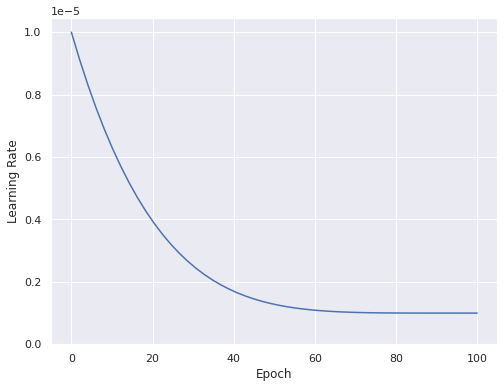

In [26]:
STEPS_PER_EPOCH = 79
EPOCHS = 100
step = np.linspace(0,EPOCHS*STEPS_PER_EPOCH)
lr_schedule = keras.optimizers.schedules.PolynomialDecay(
# lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=1e-5,
    end_learning_rate=1e-6,
    decay_steps=STEPS_PER_EPOCH*EPOCHS,
    power=5.0,
    # decay_rate=1,
)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [71]:
def LinearWarmupLearningRateScheduleWrapper(base):
    """Learning rate schedule wrapper with linear warmup.

    This function creates instances of `tf.keras.optimizers.schedules.LearningRateSchedule` which have a linear warmup prior to their normal function.
    """
    # Ensure base class is a subclass of `LearningRateSchedule`.
    assert isinstance(base, Callable)
    assert issubclass(base, tf.keras.optimizers.schedules.LearningRateSchedule)

    # Wrapper class.
    class Wrapper(base):
        def __init__(self, 
            warmup_learning_rate: float,
            warmup_steps: int,
            **kwargs,
            ):
            super().__init__(**kwargs)
            self.warmup_learning_rate = warmup_learning_rate
            self.warmup_steps = warmup_steps

            # Compute offset from base class initial value and the final warmup learning rate.
            self._step_size = super(Wrapper, self).__call__(0) - self.warmup_learning_rate

        def __call__(self, step: int):
            learning_rate = tf.cond(
                pred=tf.less(step, self.warmup_steps), # If steps < warmup_steps
                true_fn=lambda: (
                    self.warmup_learning_rate + tf.cast(step, dtype=tf.float32)/self.warmup_steps*self._step_size
                ),
                false_fn=lambda: (super(Wrapper, self).__call__(step)),
            )
            return learning_rate

        def get_config(self) -> dict:
            config = super().get_config().copy()
            config.update({
                'warmup_learning_rate': self.warmup_learning_rate,
                'warmup_steps': self.warmup_steps,
            })
            return config

    # Override the wrapper class name as seen by Python.
    Wrapper.__name__ = f"LinearWarmup{base.__name__}"

    # Add this new custom wrapper to the list of custom objects.
    keras.utils.get_custom_objects()[Wrapper.__name__] = Wrapper

    # Return the wrapper.
    return Wrapper

In [59]:
# Define data and training parameters.
epochs = 100
assets = ['aapl', 'goog', 'amzn']
in_seq_len = 30
out_seq_len = 1
shift = 1
split = (0.8, 0.15, 0.05)
in_feat = ['Open','High','Low','Close','Volume']
out_feat = ['Close']
batch_size = 128
shuffle = False
strategy = tf.distribute.get_strategy()

# Load the dataset to determine total number of batches.
dataset_train, _, _ = load_stock_dataset(
    assets=assets,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    split=split,
    in_feat=in_feat,
    out_feat=out_feat,
    batch_size=batch_size,
    shuffle=shuffle,
)
batches = tf.data.experimental.cardinality(dataset_train).numpy()
del dataset_train # Free memory.
logger.info(f"{epochs=}, {batches=}")

epochs=100, batches=91


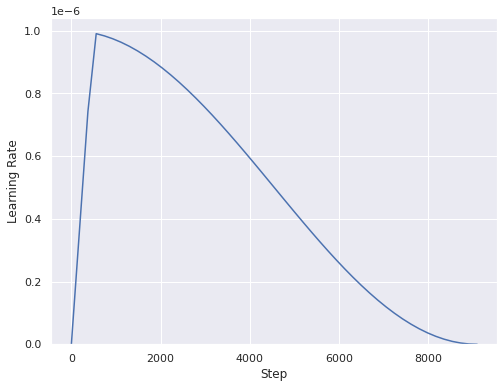

In [72]:
# Create learning rate schedule.
n_steps = epochs*batches
lr_schedule = LinearWarmupLearningRateScheduleWrapper(
    keras.experimental.CosineDecay
    )(
    warmup_learning_rate=0.0,
    warmup_steps=500,
    initial_learning_rate=1e-6,
    decay_steps=n_steps,
)
plt.figure(figsize = (8,6))
steps = np.linspace(0, n_steps)
lr = [lr_schedule(s) for s in steps]
plt.plot(steps, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Step')
_ = plt.ylabel('Learning Rate')

[transformer] Loading best model from: /home/acd1797/ml/ece_6524/final_project/checkpoints/transformer/model.h5
[transformer] Loading from save data
[transformer] Model Summary:
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 30, 20)       40          input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 30, 25)       0           input_5[0][0]                    
                                                                 time_distributed_4[0][0]         
_____________

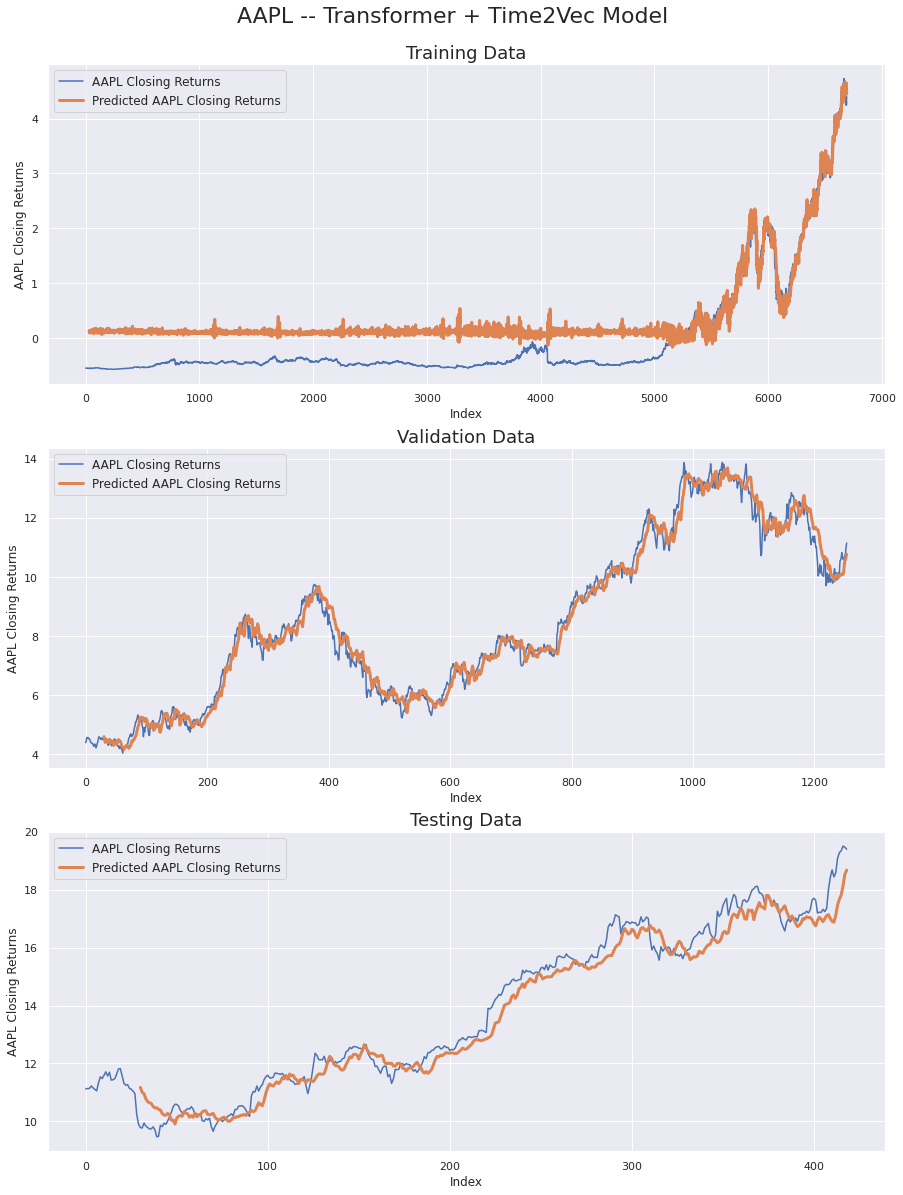

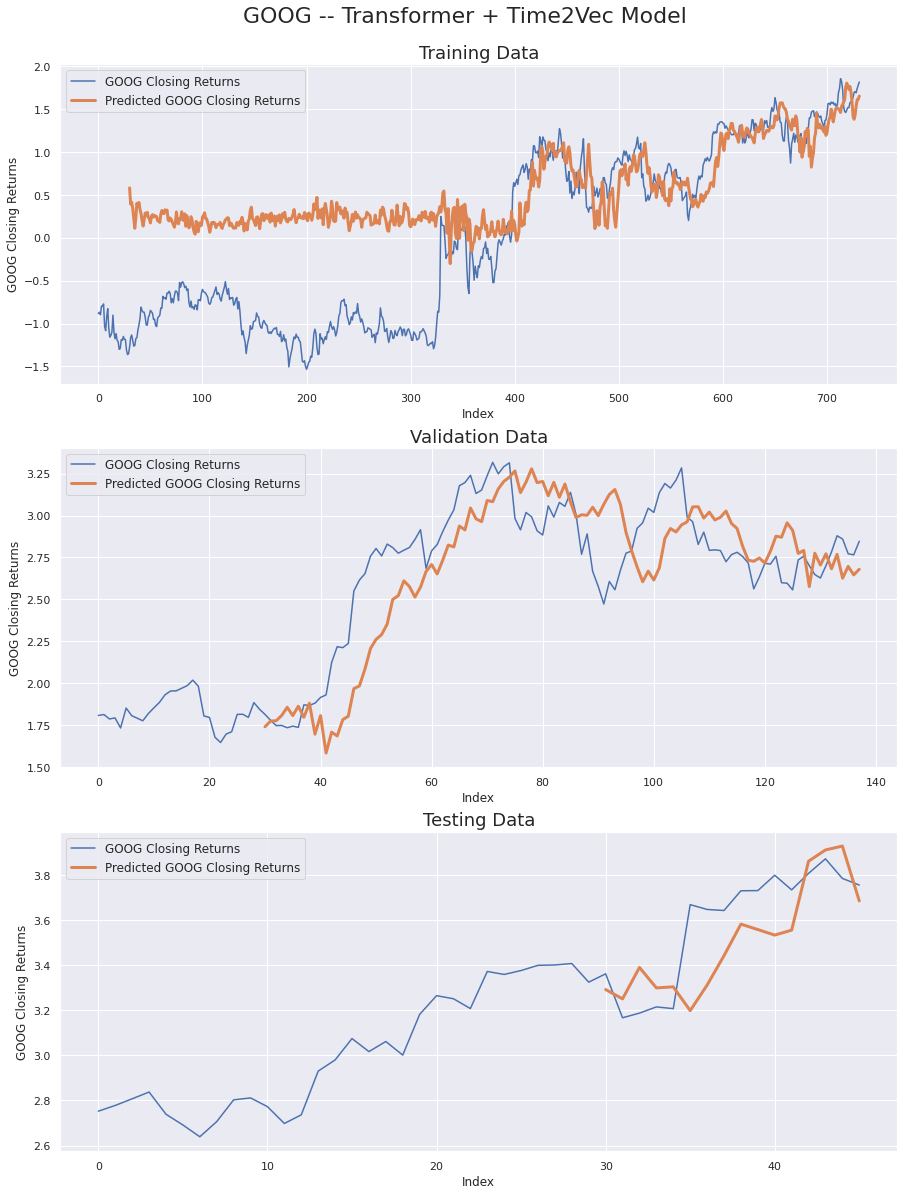

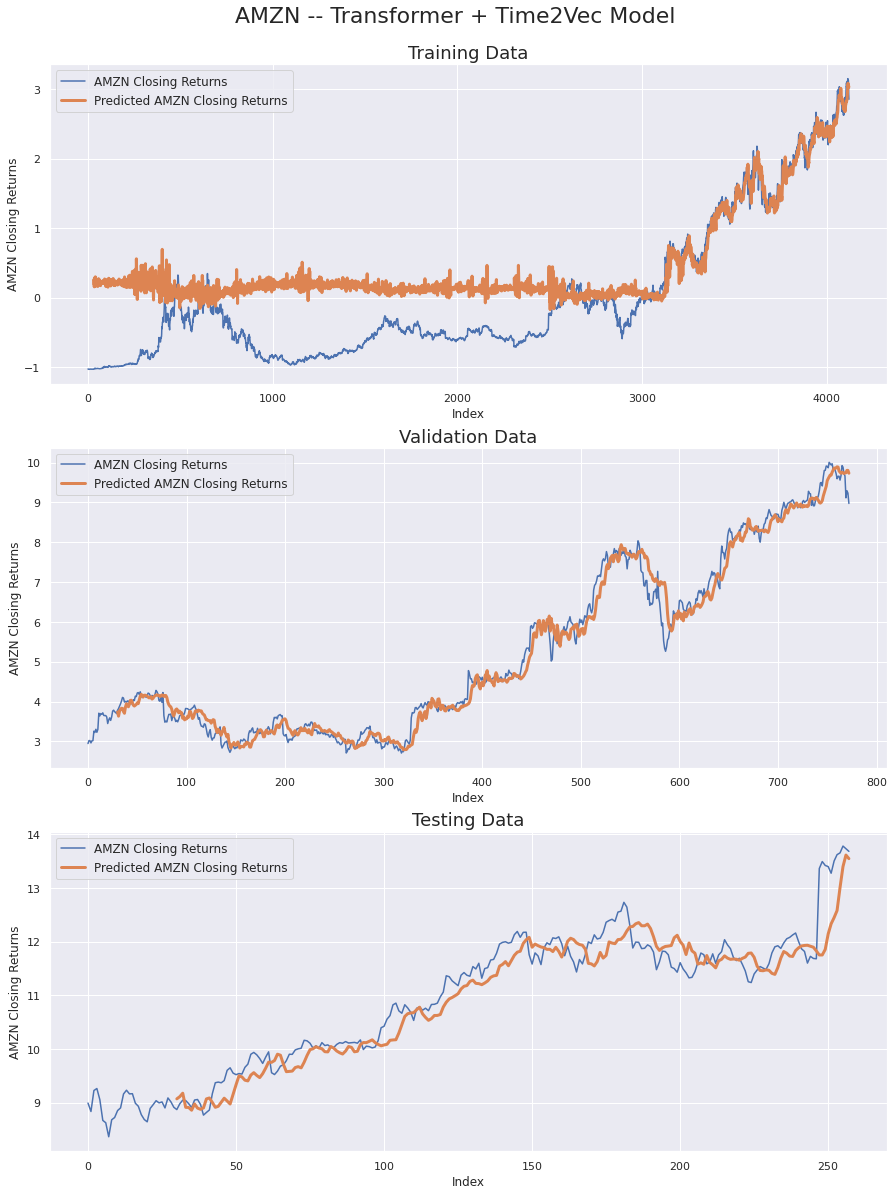

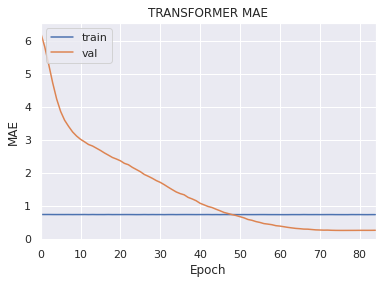

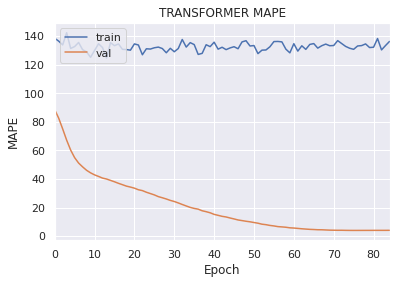

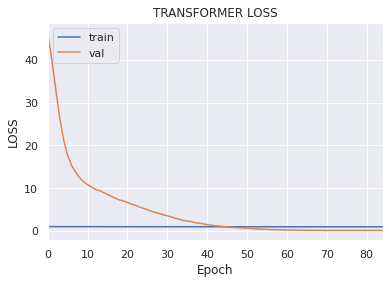

In [74]:
# Create model building function.
builder = build_model_from_hparams(build_transformer_encoder_net)

# Define model parameters.
params = dict(
    fc_units=[64,64],
    embed_dim=4,
    n_heads=8,
    ff_dim=2048,
    dropout=0.1,
    n_encoders=3,
    optim='adam',
    lr=lr_schedule,
)

# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)

# Train and evaluate the model on the desired stock data.
# model, hist, met, params, df = train_evaluate_for_dataset(
_ = train_evaluate_for_dataset(
    model_name='transformer',
    build_model_func=builder,
    params=params,
    compile_params=compile_params,
    assets=assets,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    split=split,
    in_feat=in_feat,
    out_feat=out_feat,
    batch_size=batch_size,
    shuffle=shuffle,
    strategy=strategy,
    epochs=epochs,
)

## Hyperparameter Optimization

In [31]:
# compile_params: dict,
# asset: str,
# in_seq_len: int,
# out_seq_len: int,
# shift: int,
# split: tuple[float, float, float] = (0.7, 0.2, 0.1),
# in_feat: list[str] = ['Open','High','Low','Close','Volume'],
# out_feat: list[str] = ['Open','High','Low','Close','Volume'],

def hp_gridsearch(
    model_name: str,
    build_model_func, # this function must compile the model too.
    params: dict,
    compile_params: dict,
    assets: str,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float] = (0.7, 0.2, 0.1),
    in_feat: list[str] = ['Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['Open','High','Low','Close','Volume'],
    batch_size: int = 64,
    shuffle: bool = True,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    epochs: int = 10,
    table_header: list = None,
    sort_cols: str|list[str] = None,
    sort_ascending: bool = True,
    ) -> tuple[keras.models.Model, dict, dict, pd.DataFrame]:
    """Train and evaluate a model on a given dataset.

    If checkpoint exists then the model is loaded in place of training.
    """
    # Create the tuning directory for this model if it does not already exist.
    tuning_model_root = HP_TUNING_ROOT/model_name
    tuning_model_root.mkdir(parents=True, exist_ok=True)

    # Maximize batch size efficiency using distributed strategy.
    batch_size_per_replica = batch_size
    batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

    # Convert single asset name to list.
    if isinstance(assets, str):
        assets = [assets]

    # Load the dataset.
    with strategy.scope():

        # Load the dataset.
        dataset_train, dataset_val, dataset_test = load_stock_dataset(
            assets=assets,
            in_seq_len=in_seq_len,
            out_seq_len=out_seq_len,
            shift=shift,
            split=split,
            in_feat=in_feat,
            out_feat=out_feat,
            batch_size=batch_size,
            shuffle=shuffle,
        )

    # Build the parameter grid.
    grid = ParameterGrid(params)
    n_grid = len(grid)
    logger.info(f"[{model_name}] Evaluating {n_grid} hyperparameter combinations")

    # Save parameter grid to file.
    with open(tuning_model_root/'parameter_grid.json', 'w') as f:
        json.dump(list(grid), f)

    # Iterate over the parameter grid to train the models.
    df_results: list[dict] = []
    histories: list = []
    for i, p in enumerate(grid):

        # Build current model name string.
        cur_model_name = f"model_{i}"
        logger.info(f"[{model_name}, {cur_model_name}] Parameters: {p}")

        # Build paths for train/eval checkpoint, history, and metrics.
        checkpoint_path = tuning_model_root/f"{cur_model_name}.h5"
        history_path = tuning_model_root/f"{cur_model_name}_history.csv"
        metrics_path = tuning_model_root/f"{cur_model_name}_metrics.json"
        hparams_path = tuning_model_root/f"{cur_model_name}_hparams.json"

        # Validate any existing hyperparameter combinations.
        do_load = False
        if checkpoint_path.exists() and history_path.exists() and metrics_path.exists() and hparams_path.exists():
            with open(hparams_path, 'r') as f:
                hp = json.load(f)
            do_load = (hp == p)

        # Load model from checkpoint.
        if do_load:
            logger.info(f"[{model_name}, {cur_model_name}] Loading from save data")
            hist = load_history(history_path)
            met = load_metrics(metrics_path)

        # Train the model if no checkpoint exists.
        else:
            logger.info(f"[{model_name}, {cur_model_name}] Training new model: {epochs=}, {batch_size=}")

            # Save hyperparameters to file.
            with open(hparams_path, 'w') as f:
                json.dump(p, f)

            # Build the model.
            with strategy.scope():

                # Create the model.
                logger.info(f"[{model_name}, {cur_model_name}] Model building...")
                model = build_model_func(
                    hparams=dict(
                        in_seq_len=in_seq_len,
                        in_feat=len(in_feat), # Number of input features.
                        out_feat=len(out_feat), # Number of output features.
                        **p,
                    ),
                    compile_params=compile_params,
                )
                logger.info(f"[{model_name}, {cur_model_name}] Model built: {p}")

            # Train and evaluate the model and get the trained model, history, and metrics.
            _, hist, met = train_evaluate_model(
                model,
                model_name=model_name,
                datagen_train=dataset_train,
                datagen_val=dataset_val,
                datagen_test=dataset_test,
                epochs=epochs,
                metric_list=compile_params['metrics'],
                checkpoint_path=checkpoint_path,
                history_path=history_path,
                metrics_path=metrics_path,
            )

        logger.info(f"[{model_name}, {cur_model_name}] metrics: {met}")

        # Append to lists.
        histories.append(hist)

        # Populate results list with the current parameters and metrics.
        df_results.append({
            'model': i,
            **met,
            **p,
        })

    logger.info(f"[{model_name}] Tuning Results:")

    # Build dataframe using results.
    df = pd.DataFrame(df_results)
    if table_header is not None:
        df = df[table_header]
    if sort_cols is not None:
        df = df.sort_values(by=sort_cols, ascending=sort_ascending)
    logger.info(df.to_string(index=False)) # Log to console.
    df.to_csv(TABLE_ROOT/f"{model_name}_tuning_results.csv", sep='|', index=False)

    # Export the dataframe to LaTeX using custom style.
    df.columns = df.columns.map(lambda x: x.replace('_', '\_')) # Escape the header names too.
    styler = df.style
    styler = styler.format(str, escape='latex') # Default is to convert all cells to their string representation.
    subset = []
    for m in compile_params['metrics']:
        subset.append(f"{m}")
        subset.append(f"val\_{m}")
    styler = styler.format(formatter='{:.4f}', subset=subset)
    styler = styler.highlight_max(subset=subset, axis=0, props='textbf:--rwrap;')
    styler = styler.hide(axis=0) # Hide the index.
    styler.to_latex(
        buf=TABLE_ROOT/f"{model_name}_tuning_results.tex",
        hrules=True,
    )
    df.columns = df.columns.map(lambda x: x.replace('\_', '_')) # Convert header names back.

    # List of colors for plotting.
    n = len(histories)
    color = plt.cm.rainbow(np.linspace(0, 1, n))


    # Plot train/val performance.
    for key in compile_params['metrics']+['loss']:

        fig = plt.figure(figsize=(8,6))
        for i, (h, c) in enumerate(zip(histories, color)):
            plt.plot(h[key], label=f"model {i} train", color=c, linestyle='-')
            plt.xlim(0, len(h[key])-1)
        plt.xlabel('Epoch')
        plt.ylabel(key.upper())
        plt.title(f"{model_name.upper()} Training {key.upper()}")
        plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1.04,0.5))
        fig.savefig(IMAGE_ROOT/f"{model_name}_hp_{key}_train.png", bbox_inches='tight')
        fig.show()

        fig = plt.figure(figsize=(8,6))
        for i, (h, c) in enumerate(zip(histories, color)):
            plt.plot(h[f'val_{key}'], label=f"model {i} val", color=c, linestyle='-')
            plt.xlim(0, len(h[key])-1)
        plt.xlabel('Epoch')
        plt.ylabel(key.upper())
        plt.title(f"{model_name.upper()} Validation {key.upper()}")
        plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1.04,0.5))
        fig.savefig(IMAGE_ROOT/f"{model_name}_hp_{key}_val.png", bbox_inches='tight')
        fig.show()

    # Now only load the best model.
    best_idx = df[['val_loss']].idxmin().values[0]
    best_model_name = f"model_{best_idx}"
    checkpoint_path = tuning_model_root/f"{best_model_name}.h5"
    history_path = tuning_model_root/f"{best_model_name}_history.csv"
    metrics_path = tuning_model_root/f"{best_model_name}_metrics.json"
    params = grid[best_idx]
    logger.info(f"[{model_name}] Loading best model {best_idx}: {params}")
    model = load_trained_model(checkpoint_path)
    hist = load_history(history_path)
    met = load_metrics(metrics_path)

    # Plot the best model predictions of the dataset.
    plot_predictions(
        model=model,
        hparams=params,
        assets=assets,
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        split=split,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
        strategy=strategy,
    )

    return model, hist, met, params, df

[transformer_tuned] Evaluating 8 hyperparameter combinations
[transformer_tuned, model_0] Parameters: {'d_ff': 512, 'd_k': 512, 'd_v': 256, 'embed_dim': 32, 'fc_units': [64, 64], 'lr': 0.001, 'n_heads': 8, 'optim': 'adam'}
[transformer_tuned, model_0] Loading from save data
[transformer_tuned, model_0] metrics: {'mae': 0.14150328934192657, 'val_mae': 6.631061553955078, 'test_mae': 2.7523789405822754, 'mape': 51.73185348510742, 'val_mape': 58.74818801879883, 'test_mape': 8.86485767364502, 'loss': 0.08714176714420319, 'val_loss': 59.862060546875, 'test_loss': 12.773634910583496}
[transformer_tuned, model_1] Parameters: {'d_ff': 512, 'd_k': 512, 'd_v': 256, 'embed_dim': 32, 'fc_units': [128, 128], 'lr': 0.001, 'n_heads': 8, 'optim': 'adam'}
[transformer_tuned, model_1] Loading from save data
[transformer_tuned, model_1] metrics: {'mae': 0.1324814260005951, 'val_mae': 3.7710564136505127, 'test_mae': 3.860538959503174, 'mape': 59.759159088134766, 'val_mape': 38.654300689697266, 'test_mape':

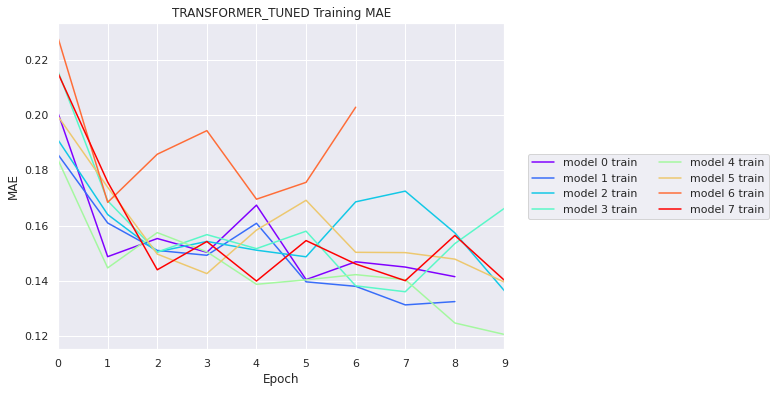

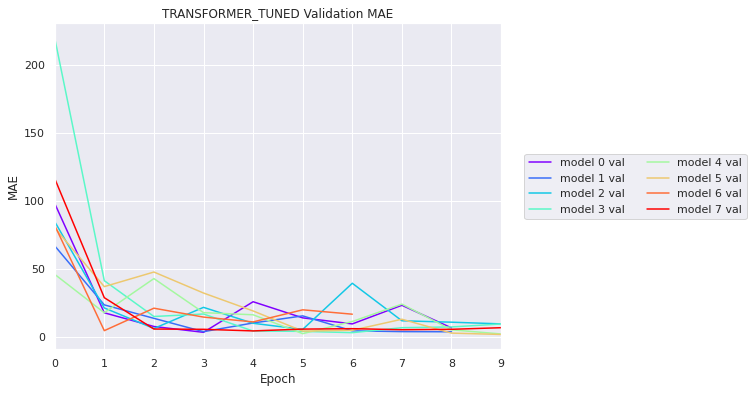

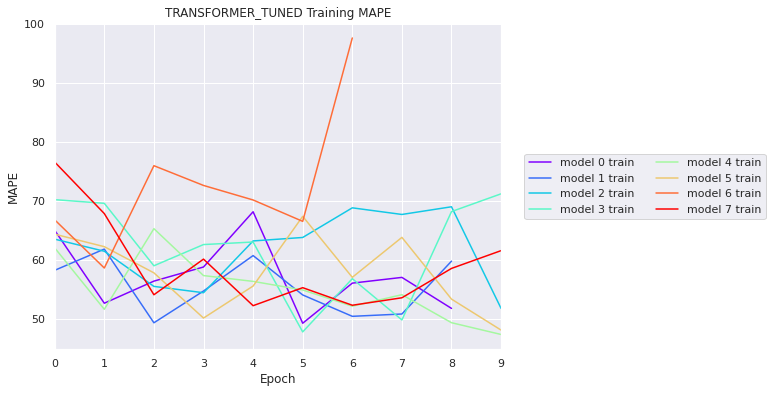

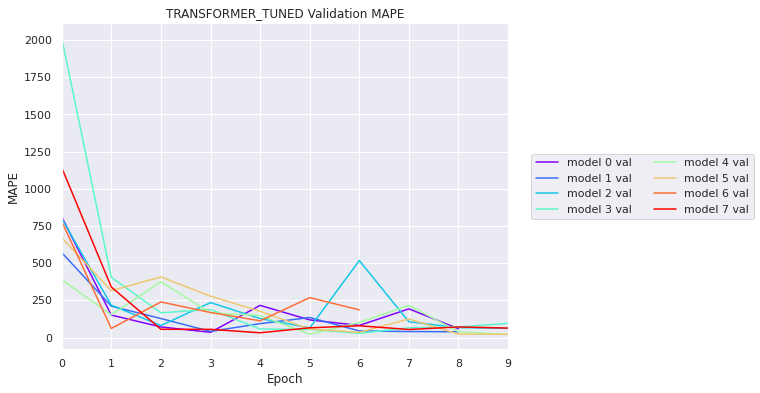

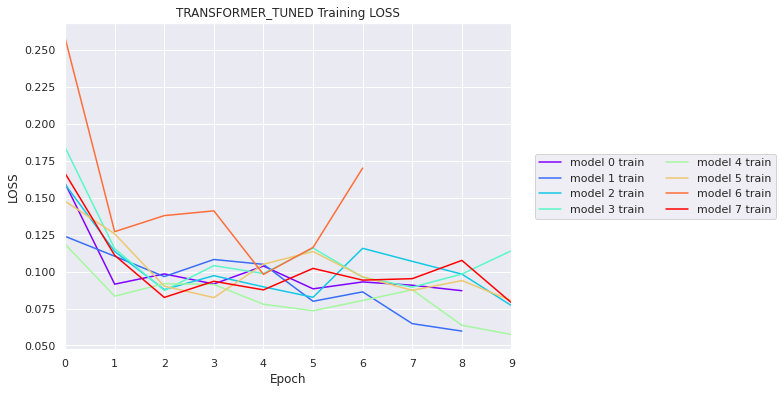

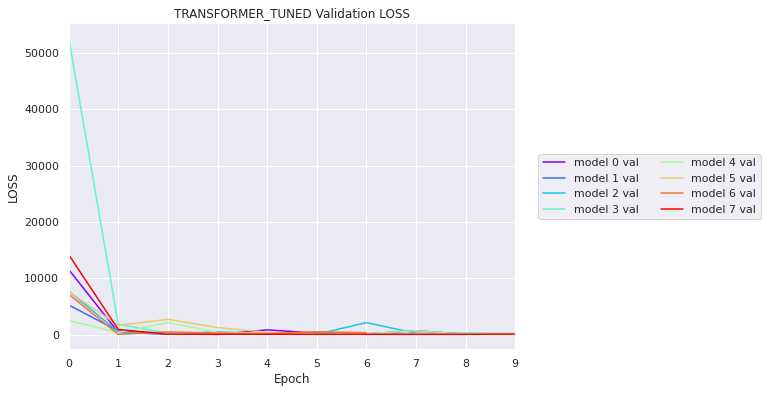

In [32]:
builder = build_model_from_hparams(build_transformer_encoder_net)

params = dict(
    fc_units=[
        [64,64],
        # [128,128],
    ],
    embed_dim=[2, 4, 8],
    n_heads=[2, 4, 8],
    d_ff=[
        1024,
        2048,
        4096,
    ],
    optim=['adam'],
    lr=[1e-4, 1e-5, 1e-6],
)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)
table_header = ['model']
for m in compile_params['metrics']+['loss']:
    table_header.append(f"{m}")
    table_header.append(f"val_{m}")
table_header.extend(list(params))

mhepd_model_tuned = hp_gridsearch(
    model_name='transformer_tuned',
    build_model_func=builder,
    params=params,
    compile_params=compile_params,
    assets=['aapl', 'goog', 'amzn'],
    in_seq_len=30,
    out_seq_len=1,
    shift=1,
    split=(0.9, 0.05, 0.05),
    in_feat=['Open','High','Low','Close','Volume'],
    # out_feat=['Open','High','Low','Close','Volume'],
    out_feat=['Close'],
    batch_size=128,
    shuffle=False,
    strategy=tf.distribute.get_strategy(),
    epochs=100,
    table_header=table_header,
    sort_cols=f"val_{compile_params['metrics'][0]}",
)